In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install gradio

In [ ]:
!pip install facenet-pytorch


In [ ]:
!pip install opencv-python


In [ ]:
import gradio as gr
import torch
import torch.nn.functional as F
from facenet_pytorch import MTCNN, InceptionResnetV1
import numpy as np
from PIL import Image
import cv2

In [ ]:
!pip install gradio torch facenet-pytorch numpy Pillow opencv-python pytorch-grad-cam


ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


In [ ]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-z3zp9zkf
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-z3zp9zkf
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 51ae19245f655cf0ee334db2a945ceb1a4d6df59
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=37432 sha256=5e2319565493c85c16eaa90c74b7860792cafcba235bc0a42b7ac6b81ebdf8d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-10sj8ycr/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

mtcnn = MTCNN(
    select_largest=False,
    post_process=False,
    device=DEVICE
).to(DEVICE).eval()

In [ ]:
model = InceptionResnetV1(
    pretrained="vggface2",
    classify=True,
    num_classes=1,
    device=DEVICE
)

checkpoint = torch.load("/content/drive/MyDrive/inceptionv3_model.pth", map_location=torch.device('cpu'))
model.to(DEVICE)
model.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
def predict(input_image: Image.Image):
    """Predict the label of the input_image"""
    face = mtcnn(input_image)
    if face is None:
        raise Exception('No face detected')
    face = face.unsqueeze(0) # add the batch dimension
    face = F.interpolate(face, size=(224, 224), mode='bilinear', align_corners=False)

    # convert the face into a numpy array to be able to plot it
    prev_face = face.squeeze(0).permute(1, 2, 0).cpu().detach().int().numpy()
    prev_face = prev_face.astype('uint8')

    face = face.to(DEVICE)
    face = face.to(torch.float32)
    face = face / 255.0
    face_image_to_plot = face.squeeze(0).permute(1, 2, 0).cpu().detach().int().numpy()

    target_layers=[model.block8.branch1[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    targets = [ClassifierOutputTarget(0)]

    grayscale_cam = cam(input_tensor=face, targets=targets, eigen_smooth=True)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(face_image_to_plot, grayscale_cam, use_rgb=True)
    face_with_mask = cv2.addWeighted(prev_face, 1, visualization, 0.5, 0)

    with torch.no_grad():
        output = torch.sigmoid(model(face).squeeze(0))
        prediction = "real" if output.item() < 0.5 else "fake"

        real_prediction = 1 - output.item()
        fake_prediction = output.item()

        confidences = {
            'real': real_prediction,
            'fake': fake_prediction
        }
    return confidences, face_with_mask


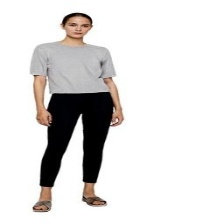

In [ ]:
from PIL import Image

input_image = Image.open("/content/drive/MyDrive/real and fake images/fake1463.jpg")
input_image

In [ ]:
confidences, face_with_mask = predict(input_image)
confidences

{'real': 0.4058248996734619, 'fake': 0.5941751003265381}

array([[[ 16,  25,  96],
        [ 16,  25,  96],
        [ 15,  25,  96],
        ...,
        [ 64,  47, 111],
        [ 67,  49, 113],
        [ 67,  49, 113]],

       [[ 16,  25,  96],
        [ 16,  25,  96],
        [ 15,  25,  96],
        ...,
        [ 64,  47, 111],
        [ 67,  49, 113],
        [ 67,  49, 113]],

       [[ 15,  25,  96],
        [ 15,  25,  96],
        [ 15,  25,  96],
        ...,
        [ 62,  45, 110],
        [ 64,  47, 111],
        [ 64,  47, 111]],

       ...,

       [[151, 161, 201],
        [151, 161, 201],
        [151, 161, 201],
        ...,
        [171, 185, 210],
        [171, 186, 211],
        [171, 186, 211]],

       [[153, 163, 203],
        [153, 163, 203],
        [153, 162, 202],
        ...,
        [171, 185, 210],
        [171, 186, 211],
        [171, 186, 211]],

       [[153, 163, 203],
        [153, 163, 203],
        [153, 162, 202],
        ...,
        [171, 185, 210],
        [171, 186, 211],
        [171, 186, 211]]], dtype=uint8)
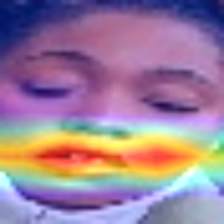

In [ ]:
face_with_mask